<a href="https://colab.research.google.com/github/ZayDest/Cancer_Classification_PSO_KNN/blob/main/Working_Feature_Selection_ToShare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy.random import rand


import numpy as np
from sklearn.neighbors import KNeighborsClassifier

import math

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Initialize positions

In [3]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

# Initialize Velocity

In [4]:
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin

# Binary Conversion

In [5]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

# Boundary

In [6]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

# Calculate Error Rate

In [7]:
# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    
    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug   
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error

# Model with selected features

In [8]:
def model_selected_feature(xtrain,xtest,ytrain, ytest,k,fmdl,sf,fs_method):  
    # model with selected features
    num_train = np.size(xtrain, 0)
    num_valid = np.size(xtest, 0)
    x_train   = xtrain[:, sf]
    y_train   = ytrain.reshape(num_train)  # Solve bug
    x_valid   = xtest[:, sf]
    y_valid   = ytest.reshape(num_valid)  # Solve bug

    mdl       = KNeighborsClassifier(n_neighbors = k) 
    print("Training Accuracy: \n")
    mdl.fit(x_train, y_train)
    # Calculate the accuracy of the training model
    train_res = mdl.score(x_train, y_train)
    print("Training Accuracy: ", train_res)
    # Predict on dataset which model has not seen before
    
    mdl.predict(x_valid)
    # Calculate the accuracy of the model
    test_res = mdl.score(x_valid, y_valid)
    print("Testing Accuracy: \n", test_res)
    
    accuracy_convergence(mdl,x_valid,y_valid,num_valid,fmdl,fs_method,opts)
    #print(sum(train_res-test_res))

# Calculate accuracy and plot convergence

In [9]:
def accuracy_convergence(mdl,x_valid,y_valid,num_valid,fmdl,fs_method,opts):
    # accuracy
    y_pred    = mdl.predict(x_valid)
    Acc       = np.sum(y_valid == y_pred)  / num_valid
    print("Accuracy:", 100 * Acc)

    # number of selected features
    num_feat = fmdl['nf']
    print("Feature Size:", num_feat)

    # plot convergence
    curve   = fmdl['c']
    curve   = curve.reshape(np.size(curve,1))
    x       = np.arange(0, opts['T'], 1.0) + 1.0

    fig, ax = plt.subplots()
    ax.plot(x, curve, 'o-')
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Fitness')
    ax.set_title(fs_method)
    ax.grid()
    plt.show()

# PSO Feature Selection

In [10]:
def pso_fs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = error_rate(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data 

# PSO

In [11]:
def pso_fs_model(opts):
    fs_method='PSO KICH'

    # perform feature selection
    fmdl = pso_fs(feat, label, opts)
    sf   = fmdl['sf']
    print('\nSelected features are : ',sf)

    model_selected_feature(xtrain,xtest,ytrain, ytest,k, fmdl, sf,fs_method)

# Data Preparation

In [12]:
rna_exp = pd.read_csv('data.csv', index_col=[0])
labels = pd.read_csv('labels_2.csv', index_col=[0])

In [13]:
feat=rna_exp
label = labels
type(feat)
feat.head()
feat=np.array(feat).reshape(-1,20531)
label=np.array(labels).reshape(-1,1)

In [14]:
print(label.shape)
print(feat.shape)
feat

(801, 1)
(801, 20531)


array([[ 0.        ,  2.01720929,  3.26552691, ...,  8.92132623,
         5.28675919,  0.        ],
       [ 0.        ,  0.59273209,  1.58842082, ...,  9.39785429,
         2.09416849,  0.        ],
       [ 0.        ,  3.51175898,  4.32719872, ..., 10.09046974,
         1.68302267,  0.        ],
       ...,
       [ 0.        ,  3.24958187,  3.70749166, ...,  9.46671072,
         4.6774575 ,  0.5866927 ],
       [ 0.        ,  2.59033853,  2.78797567, ..., 10.40058062,
         5.71875068,  0.        ],
       [ 0.        ,  2.32524248,  3.80593214, ...,  9.84479363,
         4.55071601,  0.        ]])

In [15]:
# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

In [16]:
def model_selected_feature(xtrain,xtest,ytrain, ytest,k,fmdl,sf,fs_method):  
    # model with selected features
    num_train = np.size(xtrain, 0)
    num_valid = np.size(xtest, 0)
    x_train   = xtrain[:, sf]
    y_train   = ytrain.reshape(num_train)  # Solve bug
    x_valid   = xtest[:, sf]
    y_valid   = ytest.reshape(num_valid)  # Solve bug

    #Model Fitting
    mdl       = KNeighborsClassifier(n_neighbors = k) 
    mdl.fit(x_train, y_train)
    
    # Predict on dataset which model has not seen before
    y_pred = mdl.predict(x_valid)
    print("target predicted:", y_pred)
    
    # Calculate the accuracy of the training model
    train_res = mdl.score(x_train, y_train)
    print("Training Accuracy: ", train_res)
   
    # Calculate the accuracy of the model
    test_res = mdl.score(x_valid, y_valid)
    print("Testing Accuracy score: \n", test_res)
    
    ###### FOR LOOP ###########
    neighbors = np.arange(1, len(x_train))
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    trn = np.empty(len(neighbors))
    tst = np.empty(len(neighbors))
    
    
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        
        # Compute training and test data accuracy
        train_accuracy[i] = knn.score(x_train, y_train)
        #trn = trn.append(train_accuracy[i])
        trn[i] = train_accuracy[i]
        test_accuracy[i] = knn.score(x_valid, y_valid)
        tst[i] = test_accuracy[i]
 
    print("\n train score:", trn)
    print('\n test score', tst)
    
    # Generate plot
    plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')

    plt.legend()
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')
    plt.show()
    
    accuracy_convergence(mdl,x_valid,y_valid,num_valid,fmdl,fs_method,opts)
    #print(sum(train_res-test_res))

Iteration: 1
Best (PSO): 0.008298755186721962
Iteration: 2
Best (PSO): 0.004149377593360981
Iteration: 3
Best (PSO): 0.004149377593360981
Iteration: 4
Best (PSO): 0.004149377593360981
Iteration: 5
Best (PSO): 0.004149377593360981
Iteration: 6
Best (PSO): 0.004149377593360981
Iteration: 7
Best (PSO): 0.004149377593360981
Iteration: 8
Best (PSO): 0.004149377593360981
Iteration: 9
Best (PSO): 0.004149377593360981
Iteration: 10
Best (PSO): 0.004149377593360981

Selected features are :  [    1     2     5 ... 20517 20523 20526]
target predicted: [5 4 4 4 2 1 3 1 1 4 3 3 3 2 3 3 2 3 1 4 5 1 3 3 2 4 1 2 3 2 1 2 5 5 3 5 1
 3 4 1 4 3 4 2 3 3 1 3 4 4 1 3 4 4 2 1 5 3 3 1 5 3 3 2 3 4 3 3 4 4 3 3 3 2
 1 3 1 2 3 3 4 3 3 1 4 3 1 5 3 3 3 4 3 3 4 5 3 2 3 3 4 3 3 5 2 4 2 3 5 3 1
 1 4 3 2 2 2 4 2 1 5 3 5 3 3 2 2 1 2 3 5 2 1 1 3 3 4 1 2 4 3 2 5 3 4 2 3 3
 3 1 3 4 4 3 3 4 2 4 2 4 2 4 3 2 3 4 3 4 4 4 1 2 3 3 3 3 4 4 4 3 5 3 4 1 1
 1 3 2 5 1 2 3 2 5 5 3 1 5 3 3 4 3 3 3 1 5 4 2 2 3 4 4 3 5 4 3 4 3 3 4 2 5
 3 

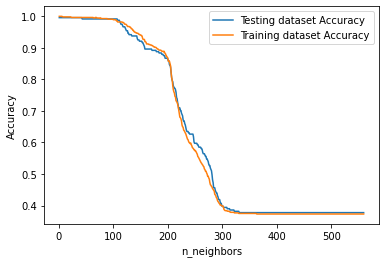

Accuracy: 99.5850622406639
Feature Size: 10338


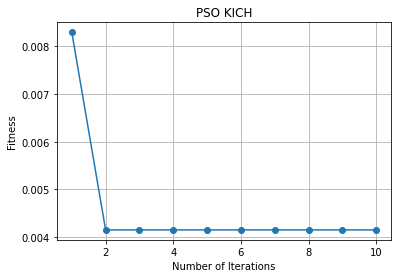

In [17]:
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 10    # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}
pso_fs_model(opts)

Iteration: 1
Best (PSO): 0.008298755186721962
Iteration: 2
Best (PSO): 0.008298755186721962
Iteration: 3
Best (PSO): 0.008298755186721962
Iteration: 4
Best (PSO): 0.008298755186721962
Iteration: 5
Best (PSO): 0.008298755186721962
Iteration: 6
Best (PSO): 0.008298755186721962
Iteration: 7
Best (PSO): 0.008298755186721962
Iteration: 8
Best (PSO): 0.008298755186721962
Iteration: 9
Best (PSO): 0.008298755186721962
Iteration: 10
Best (PSO): 0.008298755186721962

Selected features are :  [    2     3     9 ... 20525 20529 20530]
target predicted: [5 4 4 4 2 1 3 1 1 4 3 3 3 2 3 3 2 3 1 4 5 1 3 3 2 4 1 2 3 2 1 2 5 5 3 5 1
 3 4 1 4 3 4 2 3 3 1 3 4 4 1 3 4 4 2 1 5 3 3 1 5 3 3 2 3 4 3 3 4 4 3 3 3 2
 1 3 1 2 3 3 4 3 3 1 4 3 1 5 3 3 3 4 3 3 4 5 3 2 3 3 4 3 3 5 2 4 2 3 5 3 1
 1 4 3 2 2 2 4 2 1 5 3 5 3 3 2 2 1 2 3 5 2 1 1 3 3 4 1 2 4 3 2 5 3 4 2 3 3
 3 1 3 4 4 3 3 4 2 4 2 4 2 4 3 2 3 4 3 4 4 4 1 2 3 3 3 3 4 4 4 3 5 3 4 1 1
 1 3 2 5 1 2 3 2 5 5 3 1 5 3 3 4 3 3 3 1 5 4 2 2 3 4 4 3 5 4 3 4 3 3 4 2 5
 3 

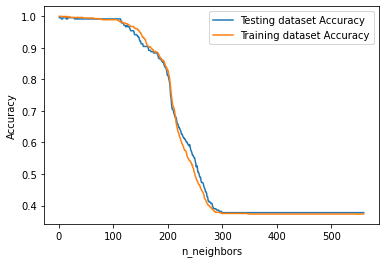

Accuracy: 99.1701244813278
Feature Size: 10238


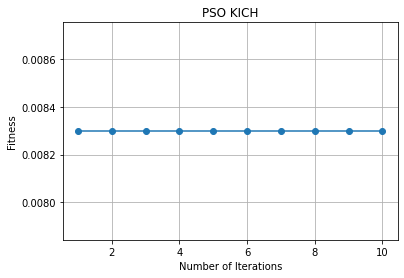

In [18]:
k    = 5     # k-value in KNN
N    = 10    # number of chromosomes
T    = 10   # maximum number of generations
CR   = 0.8
MR   = 0.01
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}
pso_fs_model(opts)